# **Import Needed Libraries**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, RFE, chi2,f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report , accuracy_score , confusion_matrix , ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from alibi.explainers import ALE
from alibi.explainers.ale import plot_ale
from sklearn.inspection import permutation_importance
from lime.lime_tabular import LimeTabularExplainer
import shap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.inspection import PartialDependenceDisplay


In [ ]:
df = pd.read_csv("/content/Super_Store_Data_After_EDA (1).csv", encoding='latin1')

In [ ]:
pip install pandas scikit-learn xgboost


**Spliting the Data**

In [ ]:
#get the median and make a condation for target col insted of being a continous data(ogistic works on probability values)
median_sales = df['Sales'].median()
df['Hights_Sales'] = (df['Sales'] >= median_sales).astype(int)

In [ ]:
print(df['Hights_Sales'].value_counts())    #Assumption one (Appropriate Outcome Type)

Hights_Sales
1    2055
0      65
Name: count, dtype: int64


In [ ]:
x = df.drop(['Sales','Hights_Sales'], axis=1)
y = df['Hights_Sales']

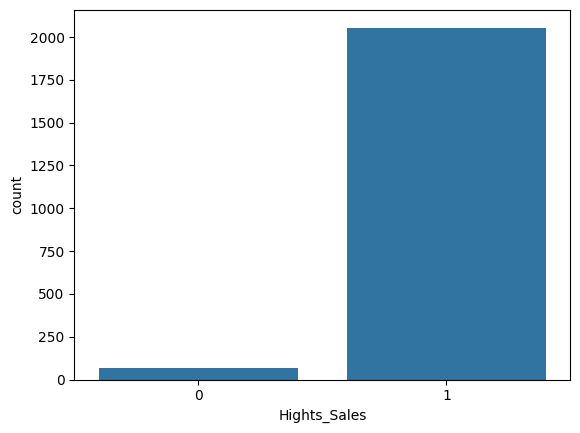

In [ ]:
sns.countplot(x='Hights_Sales', data=df)
plt.show()

In [ ]:
resambel = RandomOverSampler(random_state=42)
X_resampled, y_resampled = resambel.fit_resample(x, y)
print(y_resampled.value_counts())

Hights_Sales
1    2055
0    2055
Name: count, dtype: int64


In [ ]:
balanced_df = pd.DataFrame(X_resampled, columns=x.columns)
balanced_df['Hights_Sales'] = y_resampled

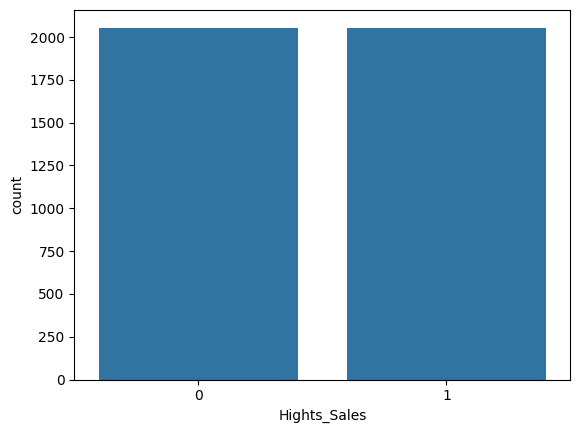

In [ ]:
sns.countplot(x='Hights_Sales', data=balanced_df)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

**Trian the data**

In [ ]:
#Standarized the numerical col
scaler = StandardScaler()
x_trained_scaled = scaler.fit_transform(X_train)
x_tested_scaled = scaler.transform(X_test)

In [ ]:
pip install alibi


In [ ]:
pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=41380aa8845547a32e68eafda017bcf8167cae97ad9233160243fbf38d75a549
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


#**2- XGBoost Model Training**

In [ ]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

In [ ]:
xgb_mse = mean_squared_error(y_test, xgb_preds)
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_r2 = r2_score(y_test, xgb_preds)
print("XGBoost Regressor Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {xgb_mse:.2f}")
print(f"Mean Absolute Error (MAE): {xgb_mae:.2f}")
print(f"R² Score: {xgb_r2:.4f}")

XGBoost Regressor Evaluation Metrics:
Mean Squared Error (MSE): 0.02
Mean Absolute Error (MAE): 0.03
R² Score: 0.9362


#**Explainabilit Techniques:-**

#**1- PDP Plots For XGBoost**

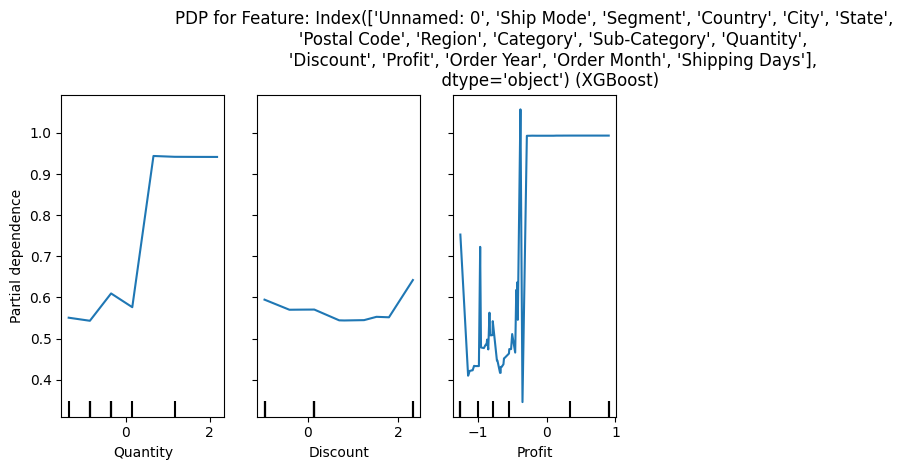

In [ ]:
# PDP Plot for XGBoost
feature_idx = [10, 11, 12]
feature_names = X_train.columns

PartialDependenceDisplay.from_estimator(xgb_model, X_test, features=feature_idx, feature_names=X_train.columns)
plt.title(f"PDP for Feature: {feature_names} (XGBoost)")
plt.tight_layout()
plt.show()


#**PDP Get raw values For XGBoost**

In [ ]:
# Get raw values
pdp_result_xgb = partial_dependence(xgb_model, X_test, features=feature_idx)
print("XGBoost PDP - Average Values:\n", pdp_result_xgb["average"])
print("XGBoost PDP - Grid Values:\n", pdp_result_xgb["grid_values"])

XGBoost PDP - Average Values:
 [[[[0.8260677  0.39471918 0.408225   ... 1.0044514  1.0044488
    1.0044488 ]
   [0.7698478  0.3405677  0.35407355 ... 1.004816   1.0048134
    1.0048134 ]
   [0.77000344 0.34072322 0.35422903 ... 1.0048763  1.0048735
    1.0048735 ]
   ...
   [0.68175405 0.34847972 0.36198556 ... 1.0090412  1.0090386
    1.0090386 ]
   [0.6802351  0.3477892  0.361295   ... 1.0083294  1.0083268
    1.0083268 ]
   [0.70885295 0.42235318 0.4290614  ... 1.0796429  1.0796549
    1.0796549 ]]

  [[0.81568617 0.38620368 0.40189818 ... 0.99525636 0.99526834
    0.99526834]
   [0.75747406 0.33006    0.3457545  ... 0.9953619  0.99537396
    0.99537396]
   [0.7585126  0.33109853 0.34679303 ... 0.99630505 0.9963171
    0.9963171 ]
   ...
   [0.69014466 0.35051405 0.36620855 ... 1.0120932  1.0121053
    1.0121053 ]
   [0.68862563 0.34981135 0.36550584 ... 1.0113692  1.0113811
    1.0113811 ]
   [0.8168586  0.46836132 0.4772582  ... 1.1338055  1.1338176
    1.1338176 ]]

  [[0.8638289

#**2- ICE Plots For XGBoost**

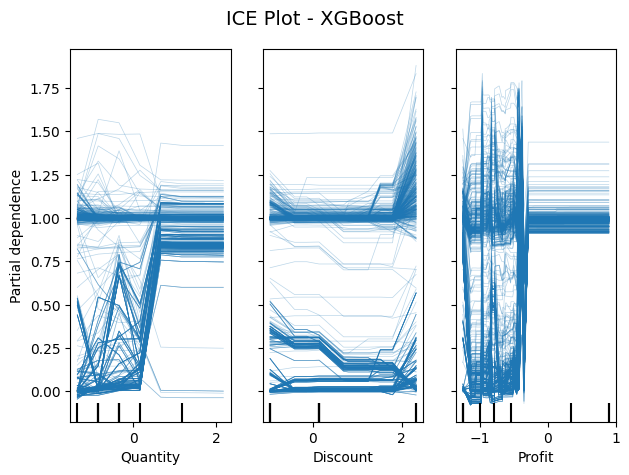

In [ ]:
PartialDependenceDisplay.from_estimator(
    xgb_model,
    X_test,
    features=feature_idx,
    kind='individual',
    feature_names=X_train.columns
)
plt.suptitle("ICE Plot - XGBoost", fontsize=14)
plt.tight_layout()
plt.show()


#**3- ALE Plots For XGBoost**

In [ ]:
# For classification (probabilities)
proba_fun_xgb = xgb_model.predict

In [ ]:
ale_xgb = ALE(
    proba_fun_xgb,
    feature_names=X_train.columns.tolist(),
    target_names=["target"]
)
exp_xgb = ale_xgb.explain(X_train.values)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


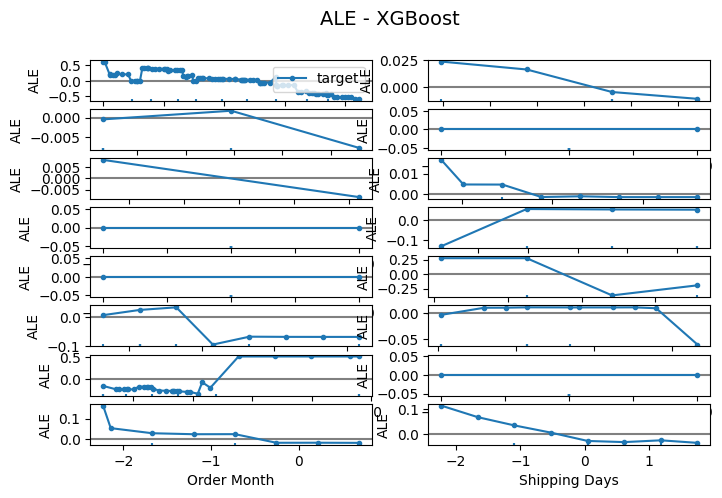

In [ ]:
plot_ale(exp_xgb, n_cols=2, fig_kw={'figwidth': 8, 'figheight': 5}, sharey=None)
plt.suptitle("ALE - XGBoost", fontsize=14)
plt.show()


#**4- Permutation Importance For XGBoost**

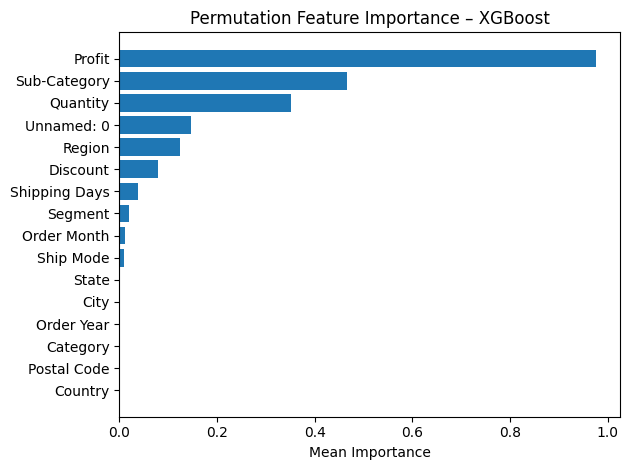

In [ ]:
# Permutation importance for XGBoost
result_xgb = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx_xgb = result_xgb.importances_mean.argsort()

# Plot
plt.barh(X_test.columns[sorted_idx_xgb], result_xgb.importances_mean[sorted_idx_xgb])
plt.title("Permutation Feature Importance – XGBoost")
plt.xlabel("Mean Importance")
plt.tight_layout()
plt.show()


#**5- Lime For XGBoost**

In [ ]:
explainer_xgb = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=np.unique(y_train).astype(str),
    mode='regression'
)

i = 0
exp_xgb = explainer_xgb.explain_instance(
    data_row=X_test.iloc[i].values,
    predict_fn=xgb_model.predict
)

exp_xgb.show_in_notebook(show_table=True)

#**6- Shap For XGBoost**

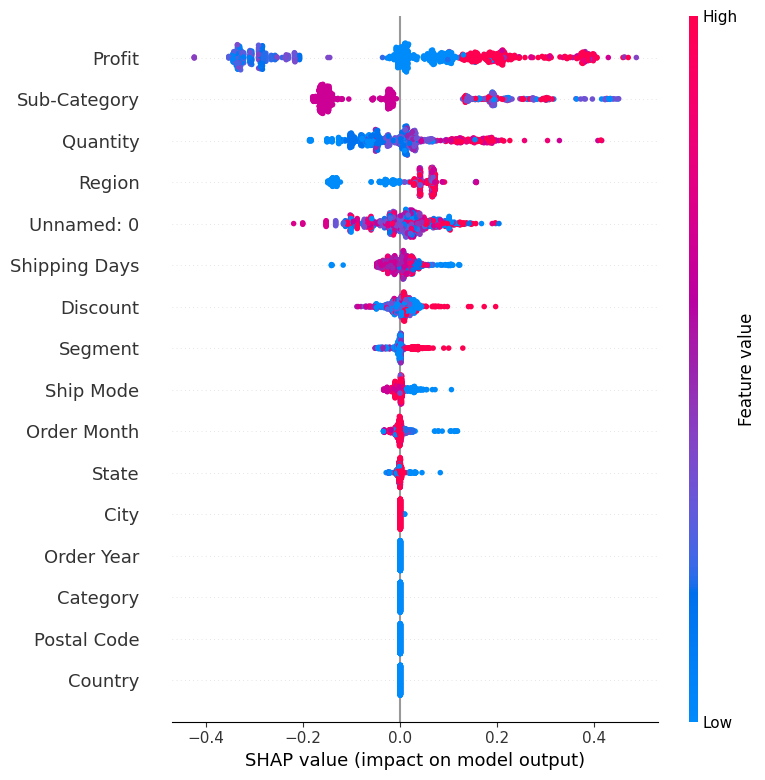

In [ ]:
explainer_xgb = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer_xgb(X_test)
shap.summary_plot(shap_values_xgb, X_test)

shap.initjs()

shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[0].values, X_test.iloc[0,:])